## 1. Data preparation

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
%matplotlib inline

# Input data files are available in the '../input/' directory.
import os
print(os.listdir("../input"))

# Any results you write to the current directory are saved as output.
import sys
print(sys.version)

['sample_submission.csv', 'plates.zip']
3.6.6 |Anaconda, Inc.| (default, Oct  9 2018, 12:34:16) 
[GCC 7.3.0]


In [2]:
# library for extract zip file
import zipfile

# let's look at the contents of the archive
data = zipfile.ZipFile('../input/plates.zip', 'r')
# data_r.printdir()

# extract the contents
data.extractall()

# let's look at the working directory
os.getcwd()

# contents of our directory
data_root = '../working/plates'
print(os.listdir(data_root))

['.DS_Store', 'train', 'test']


In [3]:
!ls -lah ../working/plates
!rm -r ../working/plates/train/cleaned/.DS_Store
!rm -r ../working/plates/train/dirty/.DS_Store

total 40K
drwxr-xr-x 4 root root 4.0K Feb 16 11:34 .
drwxr-xr-x 5 root root 4.0K Feb 16 11:34 ..
-rw-r--r-- 1 root root 6.1K Feb 16 11:34 .DS_Store
drwxr-xr-x 2 root root  20K Feb 16 11:34 test
drwxr-xr-x 4 root root 4.0K Feb 16 11:34 train


In [4]:
# Path to train dataset
PATH_TO_TRAIN = '../working/plates/train'
# Path to test dataset
PATH_TO_TEST = '../working/plates/test'
# Path to train dir
TRAIN_DIR = 'train'
# Path to test dir
TEST_DIR = 'test'
# Name of classes
labels = ['cleaned', 'dirty']

In [5]:
# Import modules for visualisation images in train dataset
from PIL import Image
from random import sample
from os.path import join
from os import listdir

cleaned


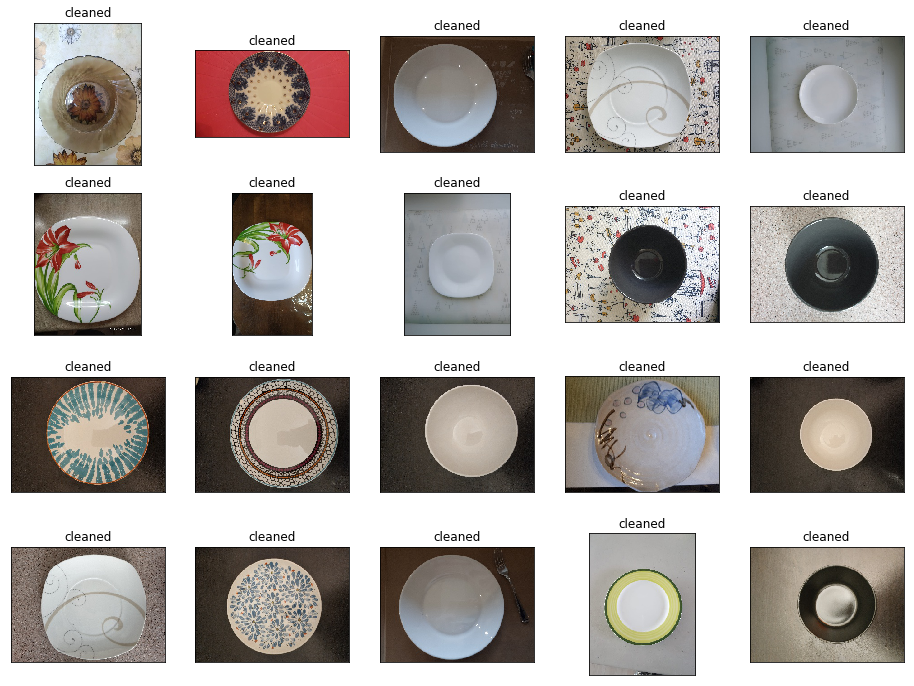

dirty


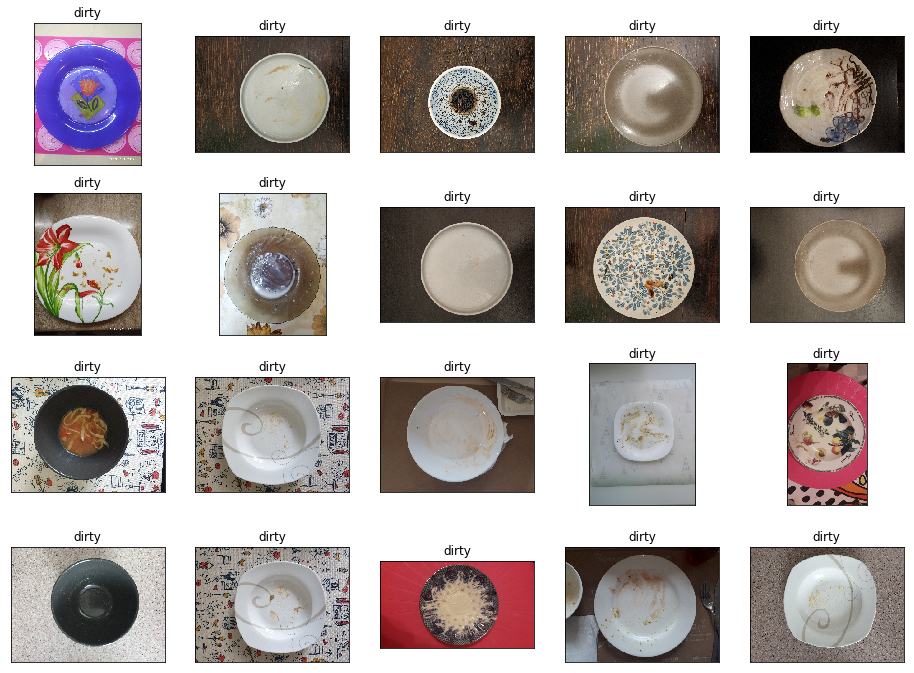

In [6]:
# visualization part of train dataset
for label in labels:
    print(label)
    # path to train dataset for label
    PATH = join(PATH_TO_TRAIN, label)
    # quantity images in train dir
    n = len(listdir(PATH))
    plt.figure(figsize=(16, 12))
    for i, image in enumerate(listdir(PATH)):
        plt.subplot(n/5, 5, i+1)
        img = Image.open(join(PATH, image))
        plt.imshow(img)
        plt.title(label)
        plt.xticks([])
        plt.yticks([])
    plt.show()

Test set


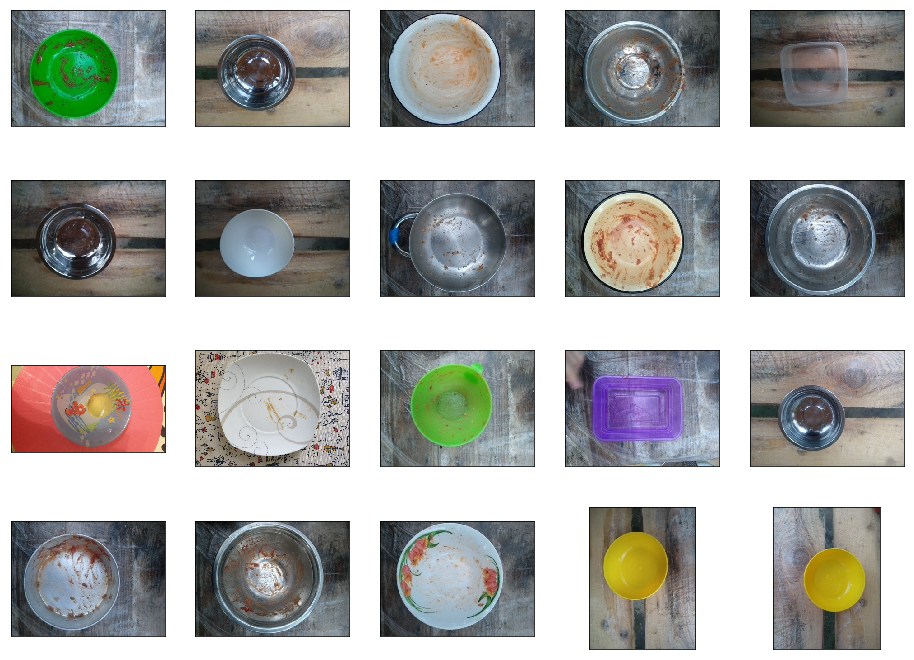

In [7]:
# visualisation part of test dataset
n_samples = 20
# shose random 20 images in test dir
sub_samples = sample(listdir(PATH_TO_TEST,), n_samples)
plt.figure(figsize=(16, 12))
print('Test set')
for i, image in enumerate(sub_samples):
    plt.subplot(n_samples/5, 5, i+1)
    img = Image.open(join(PATH_TO_TEST, image))
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
plt.show()

In [8]:
import torch
import time
import copy
import shutil
import torchvision

from tqdm import tqdm
from torchvision import transforms

In [9]:
# train_transforms_0 = transforms.Compose([
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

# train_transforms_1 = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

# train_transforms_2 = transforms.Compose([
#     transforms.Resize(224),
#     transforms.RandomHorizontalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

# train_transforms_3 = transforms.Compose([
#     transforms.CenterCrop(224),
#     transforms.RandomRotation(degrees=30),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

# train_transforms_4 = transforms.Compose([
#     transforms.Resize(224),
#     transforms.RandomVerticalFlip(),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

# train_transforms_5 = transforms.Compose([
#     transforms.RandomApply([
#         transforms.ColorJitter(
#             brightness=0.5,
#             contrast=0.5,
#             saturation=0.5,
#             hue=0.5
#         )
#     ]),
#     transforms.CenterCrop(225),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

# val_transforms = transforms.Compose([
#     transforms.Resize((224, 224)),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

# train_dataset_0 = torchvision.datasets.ImageFolder(TRAIN_DIR, train_transforms_0)
# train_dataset_1 = torchvision.datasets.ImageFolder(TRAIN_DIR, train_transforms_1)
# train_dataset_2 = torchvision.datasets.ImageFolder(TRAIN_DIR, train_transforms_2)
# train_dataset_3 = torchvision.datasets.ImageFolder(TRAIN_DIR, train_transforms_3)
# train_dataset_4 = torchvision.datasets.ImageFolder(TRAIN_DIR, train_transforms_4)
# # train_dataset_5 = torchvision.datasets.ImageFolder(TRAIN_DIR, train_transforms_5)
# # train_dataset_6 = torchvision.datasets.ImageFolder(TRAIN_DIR, train_transforms_5)

# train_dataset = torch.utils.data.ConcatDataset([train_dataset_0, 
#                                                 train_dataset_1, 
#                                                 train_dataset_2,
#                                                 train_dataset_3,
#                                                 train_dataset_4])
#                                                 train_dataset_5,
#                                                 train_dataset_6])

# val_dataset = torchvision.datasets.ImageFolder(VAL_DIR, val_transforms)

In [10]:
# train_transform = transforms.Compose([
#     transforms.RandomApply([
#         transforms.ColorJitter(
#             brightness=0.175,
#             contrast=0.175,
#             saturation=0.195,
#             hue=(0.1, 0.25)
#         )
#     ]),
#     transforms.CenterCrop(224),
#     transforms.ToTensor(),
#     transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
# ])

# train_dataset = torch.utils.data.ConcatDataset([
#     torchvision.datasets.ImageFolder(PATH_TO_TRAIN, train_transform),
#     torchvision.datasets.ImageFolder(PATH_TO_TRAIN, train_transform),
#     torchvision.datasets.ImageFolder(PATH_TO_TRAIN, train_transform),
#     torchvision.datasets.ImageFolder(PATH_TO_TRAIN, train_transform),
#     torchvision.datasets.ImageFolder(PATH_TO_TRAIN, train_transform),
#     torchvision.datasets.ImageFolder(PATH_TO_TRAIN, train_transform),
#     torchvision.datasets.ImageFolder(PATH_TO_TRAIN, train_transform),
#     torchvision.datasets.ImageFolder(PATH_TO_TRAIN, train_transform),
#     torchvision.datasets.ImageFolder(PATH_TO_TRAIN, train_transform),
#     torchvision.datasets.ImageFolder(PATH_TO_TRAIN, train_transform)
# ])

In [11]:
aug_lvl_1 = transforms.Compose([
    transforms.RandomHorizontalFlip(p=0.75),                                
    transforms.TenCrop(224, vertical_flip=True),
    transforms.Lambda(lambda crops: torch.stack([aug_lvl_2(crop) for crop in crops]))
])    

aug_lvl_2 = transforms.Compose([
    transforms.ColorJitter(
        brightness = 0.175,   
        contrast   = 0.175,   
        saturation = 0.195,   
        hue        = (0.1, 0.25)),  
    transforms.RandomRotation(360),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]),
    transforms.Lambda(lambda x: x[np.random.permutation(3), :, :])                            
])

train_transforms = transforms.Compose([  
    transforms.Resize((224, 224)),
    transforms.TenCrop(224),
    transforms.Lambda(lambda crops: torch.stack([aug_lvl_1(crop) for crop in crops]))
])

In [12]:
# Эта функия нужна, чтобы "размножить" метки.
def create_target_set(variable, size_target, dtype=torch.long): 
    target = torch.tensor([variable], dtype=dtype, requires_grad=False)
    target = torch.nn.functional.pad(target,
                                     (size_target//2, size_target//2 - 1),
                                     "constant",
                                     variable)
    return target

# Ключевая функция в данном решении. Она позволяет из 40 картинок получить 4000 тензоров!
def augmentation(dir_data, dir_transforms, batch_size, shuffle, num_workers):
    data = []
    target = []

    # Создание набора данных
    dataset = torchvision.datasets.ImageFolder(dir_data, dir_transforms)

    # Изменение размерностей тензоров и "размножение" меток
    for dt, trgt in tqdm(dataset):
        data.append(dt.resize_(100, 3, 224, 224))
        target.append(create_target_set(trgt, 100))

    # Объединение тензоров
    dtst = list(zip(torch.cat(data, dim=0), torch.cat(target, dim=0)))
    # Создание dataloader
    dataloader = torch.utils.data.DataLoader(
        dtst,
        batch_size=batch_size,
        shuffle=shuffle,
        num_workers=num_workers
        )

    return dataloader

In [13]:
batch_size = 25

train_dataloader = augmentation(
    PATH_TO_TRAIN,
    train_transforms,
    batch_size = batch_size,
    shuffle = True,
    num_workers = batch_size
    )

100%|██████████| 40/40 [00:30<00:00,  1.37it/s]


In [14]:
len(train_dataloader)

160

In [15]:
# batch_size = 25

# train_dataloader = torch.utils.data.DataLoader(train_dataset, 
#                                                batch_size=batch_size, 
#                                                shuffle=True, 
#                                                num_workers=batch_size)

In [16]:
# print(len(train_dataloader), len(train_dataset))

In [17]:
# Create function to vizualization train batch
def show_batch(X_batch, y_batch, batch_size):
    plt.figure(figsize=(16, 16))
    for i, (image_tensor, class_index) in enumerate(zip(X_batch, y_batch)):
        mean = np.array([0.485, 0.456, 0.406])
        std = np.array([0.229, 0.224, 0.225])
        image = image_tensor.permute(1, 2, 0).numpy()
        image = std * image + mean
        plt.subplot(batch_size/5, 5, i+1)
        plt.imshow(image)
        plt.title(labels[class_index])
        plt.xticks([])
        plt.yticks([])
    plt.show()

Batch 1


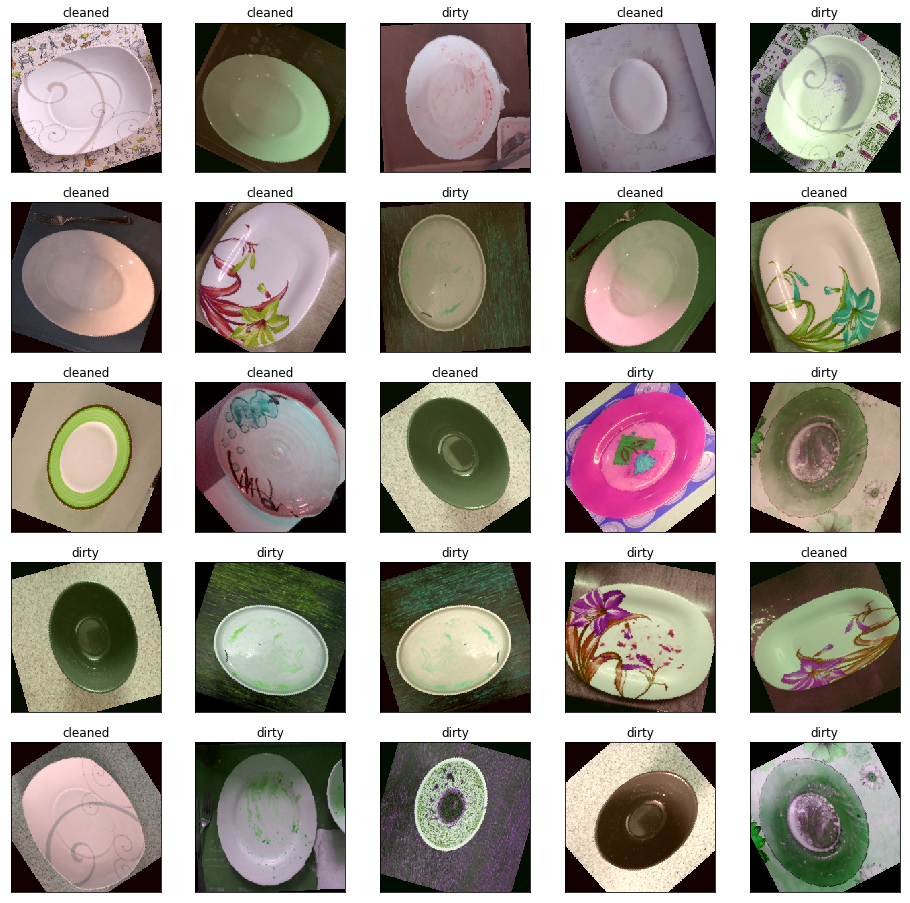

In [18]:
for i in range(1):
    print('Batch', i+1)
    X_batch, y_batch = next(iter(train_dataloader))
    show_batch(X_batch, y_batch, batch_size)

## 2. Create neural network

In [19]:
from torchvision import models

# Download pretrained model
model = models.resnet152(pretrained=True).to(device)

# Disable grad for all convolutions layers
for param in model.parameters():
    param.requires_grad = False

# Add fully connected layer
model.fc = torch.nn.Linear(model.fc.in_features, 2)

# translate model to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Select loss function
loss = torch.nn.CrossEntropyLoss()

# Select optimizer
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
# optimizer = torch.optim.Adam(model.parameters(), lr=1.0e-5, amsgrad=True)

# Decay LR by a factor of 0.1 every 4 epochs
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=4, gamma=0.001)

Downloading: "https://download.pytorch.org/models/resnet152-b121ed2d.pth" to /root/.cache/torch/checkpoints/resnet152-b121ed2d.pth
100%|██████████| 241530880/241530880 [00:02<00:00, 93673278.91it/s] 


In [20]:
def train_model(model, loss, optimizer, scheduler, num_epochs):
    # write train history for visualization
    train_accuracy_history = []
    train_loss_history = []
    
    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')

        dataloader = train_dataloader
        # Set model to training mode
        model.train()

        running_loss = 0.
        running_acc = 0.

        # Download data and grad == zero
        for inputs, labels in tqdm(dataloader):
            inputs = inputs.to(device)
            labels = labels.to(device)

            optimizer.zero_grad()
            
            # forward and backward
            preds = model(inputs)
            loss_value = loss(preds, labels)
            preds_class = preds.argmax(dim=1)

            # backward + optimize only if in training phase
            loss_value.backward()
            optimizer.step()

            # statistics
            running_loss += loss_value.data.cpu()
            running_acc += (preds_class == labels.data).float().mean().data.cpu()

        scheduler.step()
        # compute mean loss and mean accuracy
        epoch_loss = running_loss / len(dataloader)
        epoch_acc = running_acc / len(dataloader)

        # write data for visualization
        train_accuracy_history.append(epoch_acc)
        train_loss_history.append(epoch_loss)

        print(f'Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
    
    return train_accuracy_history, train_loss_history

In [21]:
history = train_model(model, loss, optimizer, scheduler, num_epochs=15);

  0%|          | 0/160 [00:00<?, ?it/s]

Epoch 1/15


  0%|          | 0/160 [00:00<?, ?it/s]

Loss: 0.4133 Acc: 0.8207
Epoch 2/15


  0%|          | 0/160 [00:00<?, ?it/s]

Loss: 0.2618 Acc: 0.9027
Epoch 3/15


  0%|          | 0/160 [00:00<?, ?it/s]

Loss: 0.2014 Acc: 0.9295
Epoch 4/15


  0%|          | 0/160 [00:00<?, ?it/s]

Loss: 0.1909 Acc: 0.9262
Epoch 5/15


  0%|          | 0/160 [00:00<?, ?it/s]

Loss: 0.1626 Acc: 0.9442
Epoch 6/15


  0%|          | 0/160 [00:00<?, ?it/s]

Loss: 0.1664 Acc: 0.9457
Epoch 7/15


  0%|          | 0/160 [00:00<?, ?it/s]

Loss: 0.1612 Acc: 0.9447
Epoch 8/15


  0%|          | 0/160 [00:00<?, ?it/s]

Loss: 0.1572 Acc: 0.9497
Epoch 9/15


  0%|          | 0/160 [00:00<?, ?it/s]

Loss: 0.1600 Acc: 0.9500
Epoch 10/15


  0%|          | 0/160 [00:00<?, ?it/s]

Loss: 0.1631 Acc: 0.9452
Epoch 11/15


  0%|          | 0/160 [00:00<?, ?it/s]

Loss: 0.1588 Acc: 0.9482
Epoch 12/15


  0%|          | 0/160 [00:00<?, ?it/s]

Loss: 0.1600 Acc: 0.9475
Epoch 13/15


  0%|          | 0/160 [00:00<?, ?it/s]

Loss: 0.1560 Acc: 0.9492
Epoch 14/15


  0%|          | 0/160 [00:00<?, ?it/s]

Loss: 0.1660 Acc: 0.9432
Epoch 15/15


100%|██████████| 160/160 [00:19<00:00,  8.98it/s]

Loss: 0.1592 Acc: 0.9495


## 3. Visualization train process

In [22]:
from torch import nn

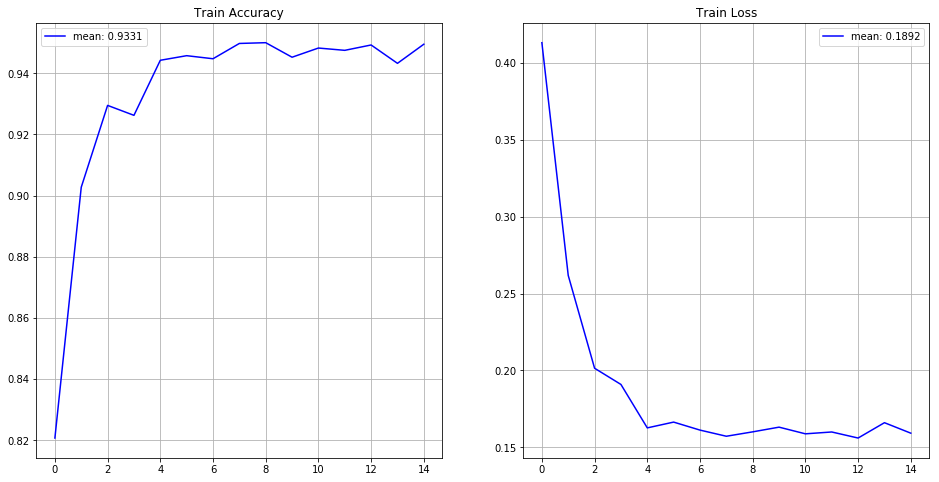

In [23]:
# Drow graph for Accuracy and Loss on train and val subset
titles = ['Train Accuracy', 'Train Loss']
plt.figure(figsize=(16, 8))
for i, image in enumerate(history):
    plt.subplot(1, 2, i+1)
    plt.title(titles[i])
    plt.grid()
    plt.plot(image, c='b', label=f'mean: {np.array(image).mean():.4f}')
    plt.legend(loc='best')
plt.show()

## 4. Classification test dataset

In [24]:
# Copy test images in dir 'test/unknown' for true work ImageFolder
test_dir = 'test'
shutil.copytree(PATH_TO_TEST, os.path.join(TEST_DIR, 'unknown'))

'test/unknown'

In [25]:
# Modify the folder with images so that it displays not only the image with its label,
# but also the path to the image
class ImageFolderWithPaths(torchvision.datasets.ImageFolder):
    def __getitem__(self, index):
        original_tuple = super(ImageFolderWithPaths, self).__getitem__(index)
        path = self.imgs[index][0]
        tuple_with_path = (original_tuple + (path,))
        return tuple_with_path

In [26]:
test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_dataset = ImageFolderWithPaths(TEST_DIR, test_transforms)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset, batch_size=batch_size, shuffle=False, num_workers=batch_size)

In [27]:
# Turn model to evel mode, parametrs do not changed
model.eval()

# predictions
test_predictions = []

# paths to images
test_img_paths = []

In [28]:
# In loop receive Batch with images, class label 'unknown' and image paths 
for inputs, labels, paths in tqdm(test_dataloader):
    inputs = inputs.to(device)
    labels = labels.to(device)
    with torch.set_grad_enabled(False):
        # count preds of model
        preds = model(inputs)
    # with SoftMax make probabilities
    # get the probability of the first class ('dirty plate')
    test_predictions.append(nn.functional.softmax(preds, dim=1)[:,1].data.cpu().numpy())
    # paths needs for visualization and save preds
    test_img_paths.extend(paths)

test_predictions = np.concatenate(test_predictions)

100%|██████████| 30/30 [00:08<00:00,  3.51it/s]


## 5. Visualization predictions

In [29]:
prediction = dict(zip(test_img_paths, test_predictions))

Test set


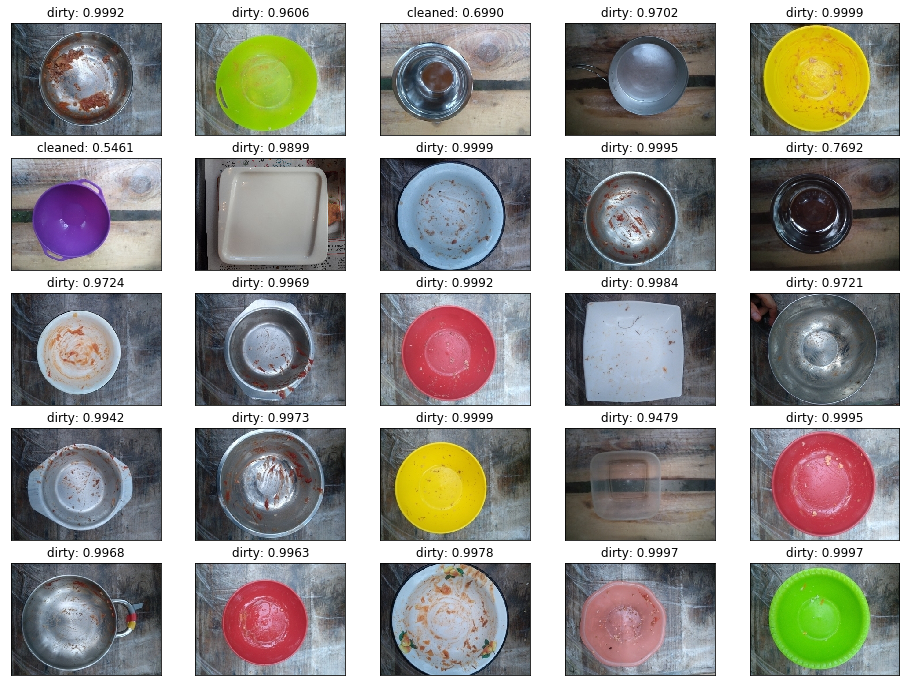

In [30]:
# Visualization predictions of classifire
n_samples = 25
sub_sample = sample(test_img_paths, n_samples)
plt.figure(figsize=(16, 12))
print('Test set')
for i, image in enumerate(sub_sample):
    plt.subplot(n_samples/5, 5, i+1)
    img = Image.open(image)
    plt.imshow(img)
    title = 'dirty' if prediction[image] > 0.75 else 'cleaned'
    title = f'{title}: {prediction[image]:.4f}'
    plt.title(title)
    plt.xticks([])
    plt.yticks([])
plt.show()

## 6. Save predictions

In [31]:
# Create DataFrame from paths to images and class labels
submission_df = pd.DataFrame.from_dict({'id': test_img_paths, 
                                        'label': test_predictions})

In [32]:
submission_df.head()

id     label
0  test/unknown/0000.jpg  0.999353
1  test/unknown/0001.jpg  0.972096
2  test/unknown/0002.jpg  0.911296
3  test/unknown/0003.jpg  0.997483
4  test/unknown/0004.jpg  0.927708

In [33]:
# Clear id, leaving only image number and transform probabilities to classes
submission_df['label'] = submission_df['label'].map(lambda pred: 'dirty' if pred > 0.75 else 'cleaned')
submission_df['id'] = submission_df['id'].str.replace('test/unknown/', '')
submission_df['id'] = submission_df['id'].str.replace('.jpg', '')
submission_df.set_index('id', inplace=True)
submission_df.head()

label
id         
0000  dirty
0001  dirty
0002  dirty
0003  dirty
0004  dirty

In [34]:
submission_df.to_csv('submission.csv')

## Delete created files

In [35]:
!rm -rf train val test